# Water Security

### Downloading all data

In [1]:
# Make sure you've run aws configure before hand
!aws s3 sync s3://s3groupegypt data

In [2]:
import datetime as dateformat
import pandas as pd
import numpy as np
from shapely.geometry import Point, box
import matplotlib.pyplot as plt
import geopandas
import geoplot
import h5py
import warnings
from tqdm import tqdm
import pickle
import re
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import torch

warnings.filterwarnings('ignore')

## Preprocessing

This section allows you to run the full pipeline from the raw data files. The full pipeline takes around 11 minutes. Alternatively, just go to the checkpoint section below and load the final master data frame.

In [3]:
# Merge 0.5x0.5 degree cells into 1x1 degree cells.
# We overlay 1x1 degree cells on the world and intersect with co-ordinates
# and aggregate using average.
# This is pretty generic and infact works with any x degree cell.
def geodataframe_overlay_grid_cells(degrees=1):
    grid = []
    for lat in np.arange(-180, 180, degrees):
        for lon in np.arange(-360, 360, degrees):
            grid.append(box(lat, lon, lat+degrees, lon+degrees))
    return grid

def geodataframe_merge_adjacent_cells(df, degrees=1, aggfunc='mean'):
    columns = df.columns[:-1]
    grid = pd.DataFrame(data={'id': np.arange(0, 360*720)})
    crs = {'init': 'epsg:4326'}
    gf = geopandas.GeoDataFrame(grid, crs=crs, geometry=geodataframe_overlay_grid_cells(degrees=degrees))
    gf_intersect = geopandas.sjoin(gf, df, how="inner", op='intersects')
    b = gf_intersect.dissolve(by='id', aggfunc=aggfunc)
    return geopandas.GeoDataFrame(b[columns], geometry=b.geometry.centroid)

# Converts dataframe to geodataframe
# Dataframe must contain lon/lat fields!
def dataframe_to_geodataframe(df):
    crs = {'init': 'epsg:4326'}
    geo = [Point(row['lon'], row['lat']) for (_, row) in df[['lon', 'lat']].iterrows()]
    gdf = geopandas.GeoDataFrame(df, crs=crs, geometry=geo)
    return gdf

frames = []

### Loading SSP2 dataset

Here we load the dataset and visualise the information with a head()/google map

In [36]:
# This dataset has population estimates every decade. We linearly impute 
# the intermediate years.
def ssp2_linear_impute(df, prefix, from_year, to_year):
    df[["%c2_%s" % (prefix, i) for i in np.arange(from_year, to_year) if i % 10]] = np.nan
    df_t = df[["%c2_%s" % (prefix, i) for i in np.arange(from_year, to_year)]].transpose()
    df_it = df_t.interpolate(method='linear', direction = 'forward').transpose()
    df_it[["lon", "lat"]] = df[["px", "py"]]
    return df_it

# Read, Impute, GeoDataFrame, Center on grid
def ssp2_load_population(from_year=1980, to_year=2017):
    population = pd.read_csv("data/SSP2/pop_ssp2.csv")
    population = ssp2_linear_impute(population, prefix="p", from_year=from_year, to_year=to_year)
    population = dataframe_to_geodataframe(population)
    population = geodataframe_merge_adjacent_cells(population)
    return population

def ssp2_load_gdp(from_year=1980, to_year=2017):
    gdp = pd.read_csv("data/SSP2/gdp_ssp2.csv")
    gdp = ssp2_linear_impute(gdp, prefix="g", from_year=from_year, to_year=to_year)
    gdp = dataframe_to_geodataframe(gdp)
    gdp = geodataframe_merge_adjacent_cells(gdp)
    return gdp

In [5]:
population = ssp2_load_population()
frames.append(population)

In [6]:
gdp = ssp2_load_gdp()
frames.append(gdp)

### Loading Water GAP dataset

Here we load the dataset and visualise the information with a head()/google map

In [6]:
#Condition- function starts from year 1980, 
# nc4_file_path -> str ,nc4_key -> str, datatype either monthly or yearly
def watergap_nc4_to_dataframe(nc4_key, nc4_file, yearN=1980):
    nc4f = h5py.File(nc4_file, 'r')
    key = nc4f[nc4_key][:]
    lat = nc4f['lat'][:]
    lon = nc4f['lon'][:]
    year = yearN
    is_monthly = 'monthly' in nc4_file

    # monthly data
    if is_monthly:
        start = (yearN - 1900 - 1)*12;
        
        #Jan of YearN to Dec of 2016
        for i in range(start, nc4f[nc4_key].shape[0]):
            data = key[i,:,:]
            if i == start:
                month = 1
                data_pd = pd.DataFrame(data = data)
                lat = nc4f['lat'][:]
                data_pd.index =  lat
                lon = nc4f['lon'][:]
                data_pd.columns = lon
                data_pd = pd.melt(data_pd, ignore_index = False, var_name='lon', value_name=str(dateformat.datetime(year, 1, month).strftime('%m/%d/%Y')))               
            else:
                data_I = pd.DataFrame(data = data)
                data_I.index =  lat
                
                if i % 12 == 0:
                    year = year+1
                    month = 1
                else:
                    month = month + 1
                    
                data_I = pd.melt(data_I,ignore_index = False, value_name= str(dateformat.datetime(year, month,1).strftime('%m/%d/%Y')))
                data_pd[str(dateformat.datetime(year,month,1).strftime('%m/%d/%Y'))] = data_I.loc[:,str(dateformat.datetime(year,month,1).strftime('%m/%d/%Y'))]
        
        # Convert to Yearly Data
        data_ion = data_pd['lon']
        data_no_ion = data_pd.drop(columns=['lon'])
        new = (data_no_ion.groupby(pd.PeriodIndex(data_no_ion.columns, freq='Y'), axis=1).mean().rename(columns=lambda c: str(c).lower()))
        data_pd=pd.concat([data_ion, new], axis=1) 
        
    # yearly data
    else:
        start = year - 1900 - 1;

        #YearN to 2016
        for i in range(start, nc4f[nc4_key].shape[0]):
            data = key[i,:,:]
            if i == start:
                data_pd = pd.DataFrame(data = data)
                lat = nc4f['lat'][:]
                data_pd.index =  lat
                lon = nc4f['lon'][:]
                data_pd.columns = lon
                data_pd = pd.melt(data_pd, ignore_index = False, var_name='lon', value_name=str(yearN))
            else:
                data_I = pd.DataFrame(data = data)
                data_I.index =  lat
                year = year+1
                data_I = pd.melt(data_I,ignore_index = False, value_name= str(year))
                data_pd[str(year)] = data_I.loc[:,str(year)]

    data_pd['lat'] = data_pd.index
    data_pd = data_pd.add_suffix('_%s' % nc4_key)
    data_pd.rename(columns={'lat_%s' % nc4_key : 'lat', 'lon_%s' % nc4_key : 'lon' }, inplace=True)
    return data_pd.reset_index(drop=True)

def watergap_load(key, period):
    filename = 'data/WaterGap/watergap_22d_WFDEI-GPCC_histsoc_%s_%s_1901_2016.nc4' % (key, period)
    d = watergap_nc4_to_dataframe(nc4_key=key, nc4_file=filename)
    return d


def watergap_load_all():
    watergap_vars = [("anag", "monthly"),
                 ("anas", "monthly"),
                 ("atotuse", "monthly"),
                 ("canopystor", "monthly"),
                 ("dis", "monthly"),
                 ("evap", "monthly"),
                 ("glolakestor", "monthly"),
                 ("glowetlandstor", "monthly"),
                 ("groundwstor", "monthly"),
                 ("loclakestor", "monthly"),
                 ("locwetlandstor", "monthly"),
                 ("ncrun", "monthly"),
                 ("pdomuse", "yearly"),
                 ("pdomww", "yearly"),
                 ("pgwuse", "monthly"),
                 ("pgwww", "monthly"),
                 ("pinduse", "yearly"),
                 ("pindww", "yearly"),
                 ("pirruse", "monthly"),
                 ("pirrww", "monthly"),
                 ("plivuse", "yearly"),
                 ("pnag", "monthly"),
                 ("pnas", "monthly"),
                 ("potevap", "monthly"),
                 ("precmon", "monthly"),
                 ("ptotuse", "monthly"),
                 ("ptotww", "monthly"),
                 ("qg", "monthly"),
                 ("ql", "monthly"),
                 ("qr", "monthly"),
                 ("qrdif", "monthly"),
                 ("qrswb", "monthly"),
                 ("qs", "monthly"),
                 ("reservoirstor", "monthly"),
                 ("riverstor", "monthly"),
                 ("soilmoist", "monthly"),
                 ("swe", "monthly"),
                 ("tws", "monthly"),
                 ("disnat", "monthly"),
                 ("ncrunnat", "monthly")]

    local_frames = []
    for (watergap_key, watergap_period) in tqdm(watergap_vars):
        local_frames.append(watergap_load(key=watergap_key, period=watergap_period))
        
    d = local_frames[0]
    for frame in local_frames[1:]:
        d = d.merge(frame)
    
    d = dataframe_to_geodataframe(d)
    d = geodataframe_merge_adjacent_cells(d)
    return d

In [7]:
watergap = watergap_load_all()
watergap.head()

100%|██████████| 40/40 [07:00<00:00, 10.52s/it]


,lon,1980_anag,1981_anag,1982_anag,1983_anag,1984_anag,1985_anag,1986_anag,1987_anag,1988_anag,...,2008_ncrunnat,2009_ncrunnat,2010_ncrunnat,2011_ncrunnat,2012_ncrunnat,2013_ncrunnat,2014_ncrunnat,2015_ncrunnat,2016_ncrunnat,geometry
id,,,,,,,,,,,,,,,,,,,,,
270,-179.5,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,...,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,POINT (-179.50000 -89.50000)
271,-179.5,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,...,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,POINT (-179.50000 -88.50000)
272,-179.5,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,...,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,POINT (-179.50000 -87.50000)
273,-179.5,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,...,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,POINT (-179.50000 -86.50000)
274,-179.5,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,...,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,POINT (-179.50000 -85.50000)


In [24]:
frames.append(watergap)

### Loading GLDAS dataset

Here we load the dataset and visualise the information with a head()/google map

In [7]:
def gldas_hdf_to_dataframe(year, month):
    year = str(year)
    hdf_file_path = 'data/gldas/GLDAS_CLSM10_M.A%s%02d.021.hdf' % (year, month)
    A = h5py.File(hdf_file_path, 'r')
    list_1 = list(A.keys())
    list_df = pd.DataFrame()
    list_df2 = pd.DataFrame()
    list_df["keys"] = list_1
    lat = A['lat']   
    lon = A['lon'] 
    data_pd = pd.DataFrame()   
    list_df2["keys"] = list_df["keys"].loc[0:37]
    count = 0
    for keys in list_df2["keys"]:
          if keys == 'ACond_tavg':
              data_arr = A[keys][0,:,:]
              data_pd = pd.DataFrame(data = data_arr)
              data_pd.columns = lon
              data_pd.index = lat
              col_n = year + "_" + keys
              data_pd = pd.melt(data_pd, ignore_index = False, var_name='lon', value_name= col_n)
          else:
              data_arr = A[keys][0,:,:]
              data = pd.DataFrame(data = data_arr)
              data.index = lat
              col_n = year + "_" + keys
              data = pd.melt(data, ignore_index = False, value_name= col_n)
              data_pd[col_n] = data.loc[:,col_n]

    data_pd['lat'] = data_pd.index
    return data_pd.reset_index(drop=True)

def gldas_load_all():
    local_frames = []
    for year in tqdm(range(2000, 2017)):
        # We need to merge one year at a time otherwise mem swapouts hit the roof
        d = [gldas_hdf_to_dataframe(year, month) for month in range(1, 13)]
        d = pd.concat(d).groupby(['lon','lat'], group_keys=False, as_index=False).mean()
        local_frames.append(d)
        
    d = local_frames[0]
    for frame in local_frames[1:]:
        d = d.merge(frame)
    d = dataframe_to_geodataframe(d)
    return d

In [8]:
gldas_df = gldas_load_all()

# Use that as main dataframe since GLDAS captures only a subset of the latitudes
# from 60 to -60, which are the interesting latitudes anyways. 
frames.insert(0, gldas_df)

100%|██████████| 17/17 [00:51<00:00,  3.05s/it]


In [9]:
gldas_df

,lon,lat,2000_ACond_tavg,2000_Albedo_inst,2000_AvgSurfT_inst,2000_CanopInt_inst,2000_ECanop_tavg,2000_ESoil_tavg,2000_Evap_tavg,2000_LWdown_f_tavg,...,2016_SoilTMP144_295cm_inst,2016_SoilTMP295_1295cm_inst,2016_SoilTMP29_68cm_inst,2016_SoilTMP68_144cm_inst,2016_Swnet_tavg,2016_TVeg_tavg,2016_TWS_inst,2016_Tair_f_inst,2016_Wind_f_inst,geometry
0,-179.5,-59.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (-179.50000 -59.50000)
1,-179.5,-58.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (-179.50000 -58.50000)
2,-179.5,-57.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (-179.50000 -57.50000)
3,-179.5,-56.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (-179.50000 -56.50000)
4,-179.5,-55.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (-179.50000 -55.50000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53995,179.5,85.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (179.50000 85.50000)
53996,179.5,86.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (179.50000 86.50000)
53997,179.5,87.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (179.50000 87.50000)
53998,179.5,88.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (179.50000 88.50000)


### Merging the dataframe

Here we load the dataset and visualise the information with a head()/google map

In [10]:
def geodataframe_spatial_merge(frames):
    main_frame = frames[0]
    for frame in frames[1:]:
        main_frame = main_frame.merge(frame)
    return main_frame

In [11]:
master_df = geodataframe_spatial_merge(frames)
master_df

,lon,lat,2000_ACond_tavg,2000_Albedo_inst,2000_AvgSurfT_inst,2000_CanopInt_inst,2000_ECanop_tavg,2000_ESoil_tavg,2000_Evap_tavg,2000_LWdown_f_tavg,...,g2_2007,g2_2008,g2_2009,g2_2010,g2_2011,g2_2012,g2_2013,g2_2014,g2_2015,g2_2016
0,-179.5,67.5,0.016219,39.998020,261.982452,0.028931,2.330008,15.343687,0.000009,229.330368,...,1.897492e-08,2.027207e-08,2.156921e-08,2.286636e-08,2.286636e-08,2.286636e-08,2.286636e-08,2.286636e-08,2.286636e-08,2.286636e-08
1,-178.5,67.5,0.016937,40.676281,262.283844,0.036311,2.233058,15.203341,0.000009,229.323456,...,2.349257e-07,2.509149e-07,2.669041e-07,2.828932e-07,2.828932e-07,2.828932e-07,2.828932e-07,2.828932e-07,2.828932e-07,2.828932e-07
2,-177.5,66.5,0.018806,39.602760,263.464081,0.022502,1.618066,16.863810,0.000009,238.398178,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,-177.5,67.5,0.017559,40.260284,263.129944,0.031821,2.382056,14.701731,0.000009,235.138351,...,1.104123e-07,1.179214e-07,1.254306e-07,1.329398e-07,1.329398e-07,1.329398e-07,1.329398e-07,1.329398e-07,1.329398e-07,1.329398e-07
4,-176.5,66.5,0.019091,39.242260,263.903259,0.020268,1.530059,16.375177,0.000009,238.532364,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10875,178.5,66.5,0.015414,39.112247,263.983429,0.027007,1.653442,18.262630,0.000010,237.184082,...,7.030474e-06,7.516608e-06,8.002743e-06,8.488877e-06,8.488877e-06,8.488877e-06,8.488877e-06,8.488877e-06,8.488877e-06,8.488877e-06
10876,178.5,67.5,0.014983,40.879303,260.781891,0.017122,1.584615,15.298200,0.000009,226.266846,...,1.404338e-05,1.501437e-05,1.598536e-05,1.695635e-05,1.695635e-05,1.695635e-05,1.695635e-05,1.695635e-05,1.695635e-05,1.695635e-05
10877,178.5,68.5,0.013615,-796.932922,259.243500,0.017424,1.510876,12.922237,0.000008,224.636765,...,2.841177e-06,3.035084e-06,3.228991e-06,3.422898e-06,3.422898e-06,3.422898e-06,3.422898e-06,3.422898e-06,3.422898e-06,3.422898e-06
10878,179.5,66.5,0.015795,39.452206,263.995148,0.018649,1.290685,19.071337,0.000010,236.835693,...,4.243167e-06,4.534852e-06,4.826536e-06,5.118220e-06,5.118220e-06,5.118220e-06,5.118220e-06,5.118220e-06,5.118220e-06,5.118220e-06


# Checkpoint (save/load)

In [54]:

def save_checkpoint(df, name):
    with open(name, 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_checkpoint(name):
    with open(name, 'rb') as handle:
        return pickle.load(handle)

# Do not uncomment this unless you want to save a new version of the master dataframe
# save_checkpoint(master_df, name='data/master_df.pickle')

master_df = load_checkpoint('data/master_df.pickle')

In [5]:
master_df

,lon,lat,2000_ACond_tavg,2000_Albedo_inst,2000_AvgSurfT_inst,2000_CanopInt_inst,2000_ECanop_tavg,2000_ESoil_tavg,2000_Evap_tavg,2000_LWdown_f_tavg,...,2007_ncrunnat,2008_ncrunnat,2009_ncrunnat,2010_ncrunnat,2011_ncrunnat,2012_ncrunnat,2013_ncrunnat,2014_ncrunnat,2015_ncrunnat,2016_ncrunnat
0,-179.5,67.5,0.016219,39.998020,261.982452,0.028931,2.330008,15.343687,0.000009,229.330368,...,0.000014,0.000015,0.000024,0.000019,0.000029,0.000019,0.000016,0.000025,0.000026,0.000019
1,-178.5,67.5,0.016937,40.676281,262.283844,0.036311,2.233058,15.203341,0.000009,229.323456,...,0.000012,0.000012,0.000020,0.000015,0.000024,0.000017,0.000013,0.000022,0.000022,0.000018
2,-177.5,66.5,0.018806,39.602760,263.464081,0.022502,1.618066,16.863810,0.000009,238.398178,...,0.000011,0.000007,0.000019,0.000014,0.000023,0.000012,0.000011,0.000018,0.000018,0.000017
3,-177.5,67.5,0.017559,40.260284,263.129944,0.031821,2.382056,14.701731,0.000009,235.138351,...,0.000006,0.000006,0.000011,0.000008,0.000013,0.000010,0.000007,0.000013,0.000013,0.000010
4,-176.5,66.5,0.019091,39.242260,263.903259,0.020268,1.530059,16.375177,0.000009,238.532364,...,0.000010,0.000006,0.000016,0.000012,0.000019,0.000011,0.000009,0.000016,0.000016,0.000017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10875,178.5,66.5,0.015414,39.112247,263.983429,0.027007,1.653442,18.262630,0.000010,237.184082,...,0.000013,0.000010,0.000021,0.000017,0.000026,0.000014,0.000014,0.000019,0.000019,0.000015
10876,178.5,67.5,0.014983,40.879303,260.781891,0.017122,1.584615,15.298200,0.000009,226.266846,...,0.000011,0.000014,0.000019,0.000016,0.000023,0.000016,0.000014,0.000020,0.000020,0.000011
10877,178.5,68.5,0.013615,-796.932922,259.243500,0.017424,1.510876,12.922237,0.000008,224.636765,...,0.000008,0.000012,0.000009,0.000010,0.000012,0.000013,0.000009,0.000011,0.000011,0.000008
10878,179.5,66.5,0.015795,39.452206,263.995148,0.018649,1.290685,19.071337,0.000010,236.835693,...,0.000012,0.000010,0.000020,0.000017,0.000027,0.000014,0.000013,0.000019,0.000019,0.000015


# World Poverty Index

Mozambique


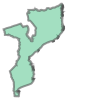

In [10]:
from shapely import wkt

wpif = pd.read_csv("data/wpif.csv")
wpif = wpif.replace(-999.0, 0.0)
mozambique = wkt.loads(wpif.iloc[0]['the_geom'])
print(wpif.iloc[0]['NAME'])
mozambique

In [11]:
master_df[master_df.intersects(mozambique)].shape
# 33 1 degree cells match mozambique

(33, 2203)

In [12]:
def geodataframe_merge_wpi(df):
    crs = {'init': 'epsg:4326'}
    geo = [wkt.loads(mpolygons) for mpolygons in wpif['the_geom']]
    wpif_gf = geopandas.GeoDataFrame(wpif, crs=crs, geometry=geo)
    return geopandas.sjoin(df, wpif_gf, how="inner", op='intersects')

gdf_intersect = geodataframe_merge_wpi(master_df)
gdf_intersect

,lon,lat,2000_ACond_tavg,2000_Albedo_inst,2000_AvgSurfT_inst,2000_CanopInt_inst,2000_ECanop_tavg,2000_ESoil_tavg,2000_Evap_tavg,2000_LWdown_f_tavg,...,2015_ncrunnat,2016_ncrunnat,index_right,FID,the_geom,OBJECTID,ISO,NAME,UNESCOMEMB,WPI
0,-179.5,67.5,0.016219,39.998020,261.982452,0.028931,2.330008,15.343687,0.000009,229.330368,...,0.000026,0.000019,209,wpif.211,MULTIPOLYGON (((146.01804100000004 43.37793940...,204,RUS,Russian Federation,Russian Federation,63.4
1,-178.5,67.5,0.016937,40.676281,262.283844,0.036311,2.233058,15.203341,0.000009,229.323456,...,0.000022,0.000018,209,wpif.211,MULTIPOLYGON (((146.01804100000004 43.37793940...,204,RUS,Russian Federation,Russian Federation,63.4
2,-177.5,66.5,0.018806,39.602760,263.464081,0.022502,1.618066,16.863810,0.000009,238.398178,...,0.000018,0.000017,209,wpif.211,MULTIPOLYGON (((146.01804100000004 43.37793940...,204,RUS,Russian Federation,Russian Federation,63.4
3,-177.5,67.5,0.017559,40.260284,263.129944,0.031821,2.382056,14.701731,0.000009,235.138351,...,0.000013,0.000010,209,wpif.211,MULTIPOLYGON (((146.01804100000004 43.37793940...,204,RUS,Russian Federation,Russian Federation,63.4
4,-176.5,66.5,0.019091,39.242260,263.903259,0.020268,1.530059,16.375177,0.000009,238.532364,...,0.000016,0.000017,209,wpif.211,MULTIPOLYGON (((146.01804100000004 43.37793940...,204,RUS,Russian Federation,Russian Federation,63.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10811,169.5,-44.5,0.022976,19.539923,275.850525,0.094677,7.432333,31.183109,0.000018,292.664368,...,0.000029,0.000037,189,wpif.189,MULTIPOLYGON (((169.1988525390001 -52.46692275...,179,NZL,New Zealand,New Zealand,60.8
10819,170.5,-44.5,0.024121,17.699976,278.923218,0.073006,9.571005,40.399059,0.000024,296.372131,...,0.000005,0.000007,189,wpif.189,MULTIPOLYGON (((169.1988525390001 -52.46692275...,179,NZL,New Zealand,New Zealand,60.8
10835,172.5,-42.5,0.024165,14.778844,278.754700,0.151941,12.595078,33.358429,0.000023,311.685425,...,0.000029,0.000032,189,wpif.189,MULTIPOLYGON (((169.1988525390001 -52.46692275...,179,NZL,New Zealand,New Zealand,60.8
10857,175.5,-38.5,0.020660,17.081402,285.399811,0.174712,12.089117,27.376980,0.000018,322.678406,...,0.000024,0.000023,189,wpif.189,MULTIPOLYGON (((169.1988525390001 -52.46692275...,179,NZL,New Zealand,New Zealand,60.8


# Remove non-reporters

In [13]:
gdf_intersect.shape

(10875, 2211)

In [14]:
gdf_intersect = gdf_intersect[gdf_intersect['WPI'] != 0]

In [15]:
gdf_intersect.shape

(10652, 2211)

# Standardizing

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

xscaler = StandardScaler().fit(gdf_intersect.filter(regex=".*2016.*"))
yscaler = MinMaxScaler().fit(np.array(gdf_intersect['WPI']).reshape(-1, 1))

# Lasso

In [17]:
from sklearn.linear_model import LassoCV, Lasso

lasso_x = xscaler.transform(gdf_intersect.filter(regex=".*2016.*"))
lasso_y = yscaler.transform(np.array(gdf_intersect['WPI']).reshape(-1, 1))

lasso = LassoCV(cv=20, random_state=42).fit(lasso_x, lasso_y)
lasso.score(lasso_x, lasso_y)

0.4424165348879575

In [18]:
interesting_var_names = gdf_intersect.filter(regex=".*2016.*").columns[np.where(lasso.coef_ != 0)]
interesting_vars = np.where(lasso.coef_ != 0)[0]
print(len(interesting_var_names))
", ".join([str(m) for m in interesting_var_names])

24


'2016_ACond_tavg, 2016_Albedo_inst, 2016_ESoil_tavg, 2016_Evap_tavg, 2016_LWdown_f_tavg, 2016_Psurf_f_inst, 2016_Qair_f_inst, 2016_Qg_tavg, 2016_Qh_tavg, 2016_Qle_tavg, 2016_Rainf_f_tavg, 2016_SWE_inst, 2016_SWdown_f_tavg, 2016_SnowDepth_inst, 2016_SnowT_tavg, 2016_SoilMoist_P_inst, 2016_SoilMoist_RZ_inst, 2016_Swnet_tavg, 2016_TVeg_tavg, 2016_TWS_inst, 2016_Tair_f_inst, 2016_Wind_f_inst, p2_2016, g2_2016'

In [19]:
predicted_y = lasso.predict(lasso_x)

lasso_results = [["Country", "Actual", "Predicted"]]
for country in list(set(gdf_intersect['ISO'])):
    actual = np.median(lasso_y[gdf_intersect['ISO'] == country])
    predicted = np.median(predicted_y[gdf_intersect['ISO'] == country].astype(float))
    lasso_results.append([country, actual, predicted])

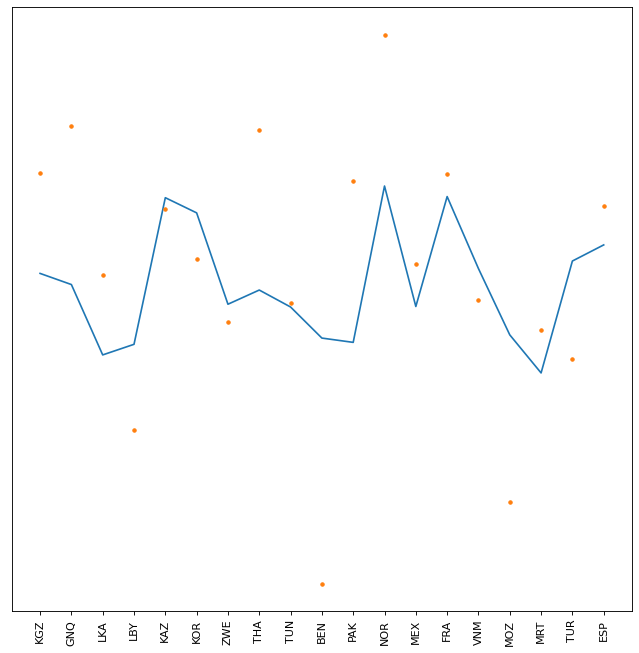

In [20]:
lasso_results = np.array(lasso_results)
plt.figure(figsize=(10, 10), dpi=80)
plt.xticks(rotation=90)
plt.yticks(np.arange(-1000, 100, step=50))
plt.plot(lasso_results[1:20,0], lasso_results[1:20,2].astype(float))
plt.plot(lasso_results[1:20,0], lasso_results[1:20,1].astype(float), '.')
plt.show()

# LSTM

In [21]:
def rnn_interesting_columns(frame, year=2016):
    x_scaled = xscaler.transform(frame.filter(regex=".*%s.*" % year))
    return pd.DataFrame(x_scaled)

rnn_gdf_intersect = gdf_intersect.copy()
rnn_input_size = len(rnn_interesting_columns(rnn_gdf_intersect).columns)
rnn_hidden_dim = 5
rnn_seq_len = 20
rnn_n_layers = 3
rnn_output_size = 1
rnn_batch_size = 60

In [22]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = torch.nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)   
        self.fc = torch.nn.Linear(hidden_dim, output_size)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, hidden = self.lstm(x, hidden)
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        out = self.sigmoid(out)
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        state = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return (hidden, state)

def sequify_countries(countries, df, interesting_columns=rnn_interesting_columns):
    seqs = np.zeros((len(countries), rnn_seq_len, rnn_input_size))
    target = np.zeros((len(countries), rnn_output_size))
    for i, country in enumerate(countries):
        country_frame = df[df['ISO'] == country]
        country_full_seq = np.zeros((rnn_seq_len, rnn_input_size))
        country_seq = interesting_columns(country_frame)
        country_full_seq[:len(country_seq),:] = country_seq[:rnn_seq_len]
        seqs[i] = country_full_seq
        target[i] = yscaler.transform(country_frame['WPI'].iloc[-1].reshape((-1, 1)))
    return (seqs, target)

def rnn_get_batch(train_seqs, train_targets, batch_size):
    sampler = np.random.choice(np.arange(train_seqs.shape[0]), size=batch_size, replace=False)
    input_seq = np.zeros((batch_size, rnn_seq_len, rnn_input_size), dtype=np.float32)
    input_seq[:,:,:] = train_seqs[sampler,:,:]
    target_seq = train_targets[sampler].squeeze()
    return torch.from_numpy(input_seq), torch.Tensor(target_seq)

def rnn_validation_loss():
    tseqs, ttargets = rnn_get_batch(rnn_test_seqs, rnn_test_targets, rnn_test_seqs.shape[0])
    tseqs.to(device)
    output, _ = model(tseqs)
    validation_loss = mse_loss(output, ttargets)
    return validation_loss.item()

In [25]:
countries = list(set(gdf_intersect['ISO']))
rnn_train_countries, rnn_test_countries = train_test_split(countries, test_size=0.2, random_state=42)
rnn_train_seqs, rnn_train_targets = sequify_countries(rnn_train_countries, rnn_gdf_intersect)
rnn_test_seqs, rnn_test_targets = sequify_countries(rnn_test_countries, rnn_gdf_intersect)
device = touch.device("GPU") if torch.cuda.is_available() else torch.device("cpu")

In [328]:
model = LSTMModel(input_size=rnn_input_size, 
                 output_size=rnn_output_size,
                 hidden_dim=rnn_hidden_dim, 
                 n_layers=rnn_n_layers)
model.to(device)

n_epochs = 2000
lr = 0.01
mse_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
losses = []
vlosses = []
lowest_vloss = 1
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    input_seq, target_seq = rnn_get_batch(rnn_train_seqs, rnn_train_targets, rnn_batch_size)
    input_seq.to(device)
    output, hidden = model(input_seq)
    loss = mse_loss(output, target_seq)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    vloss = rnn_validation_loss()
    vlosses.append(vloss)
    if vloss < lowest_vloss:
        # Save model with the lowest validation loss
        torch.save(model, "data/lstm.nn")
        lowest_vloss = vloss
    if epoch%100 == 0:
        print('Epoch: {}/{}...'.format(epoch, n_epochs), end=' ')
        print('Loss: {:.4f}...'.format(loss.item()), end=' ')
        print('Validation loss: {:.4f}'.format(vloss))

print("Saved model with lowest validation loss (%s) to data/lstm.nn" % lowest_vloss)

Epoch: 100/2000... Loss: 0.0334... Validation loss: 0.0554
Epoch: 200/2000... Loss: 0.0321... Validation loss: 0.0448
Epoch: 300/2000... Loss: 0.0357... Validation loss: 0.0555
Epoch: 400/2000... Loss: 0.0441... Validation loss: 0.0559
Epoch: 500/2000... Loss: 0.0394... Validation loss: 0.0552
Epoch: 600/2000... Loss: 0.0410... Validation loss: 0.0546
Epoch: 700/2000... Loss: 0.0342... Validation loss: 0.0498
Epoch: 800/2000... Loss: 0.0364... Validation loss: 0.0530
Epoch: 900/2000... Loss: 0.0258... Validation loss: 0.0477
Epoch: 1000/2000... Loss: 0.0160... Validation loss: 0.0472
Epoch: 1100/2000... Loss: 0.0119... Validation loss: 0.0519
Epoch: 1200/2000... Loss: 0.0054... Validation loss: 0.0654
Epoch: 1300/2000... Loss: 0.0028... Validation loss: 0.0564
Epoch: 1400/2000... Loss: 0.0011... Validation loss: 0.0652
Epoch: 1500/2000... Loss: 0.0045... Validation loss: 0.0558
Epoch: 1600/2000... Loss: 0.0017... Validation loss: 0.0595
Epoch: 1700/2000... Loss: 0.0009... Validation lo

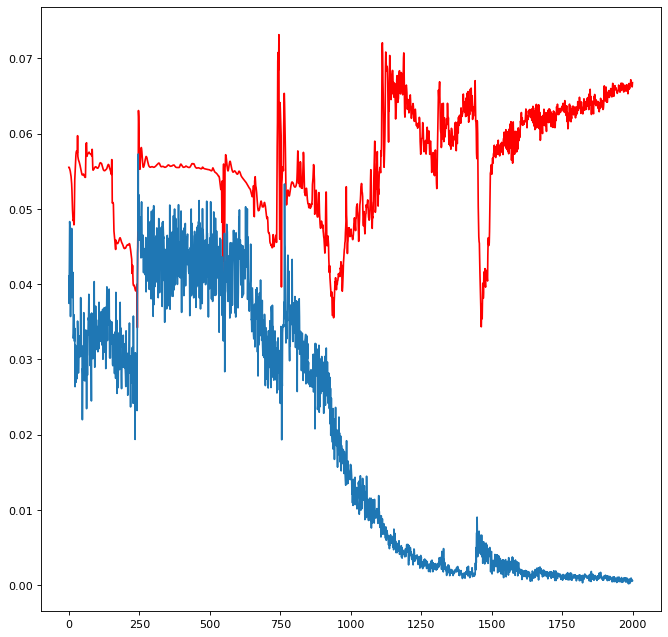

In [329]:
plt.figure(figsize=(10, 10), dpi=80)
plt.plot(vlosses, 'r')
plt.plot(losses)

# Loading LSTM model

In [26]:
lstm_model = torch.load("data/lstm.nn")
lstm_model.eval()

LSTMModel(
  (lstm): LSTM(80, 5, num_layers=3, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

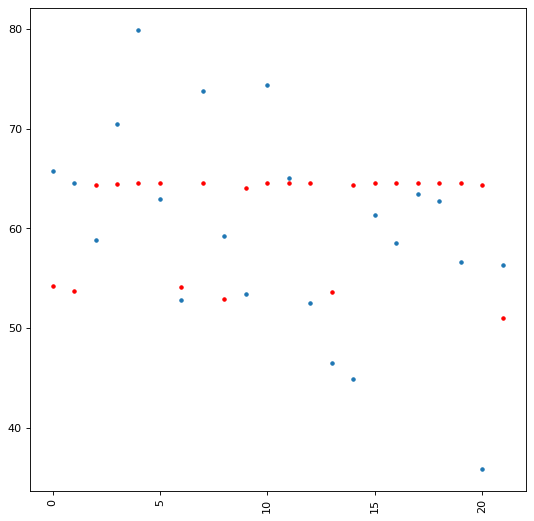

In [27]:
tseqs, ttargets = rnn_get_batch(rnn_test_seqs, rnn_test_targets, rnn_test_seqs.shape[0])
tseqs.to(device)
output, _ = lstm_model(tseqs)


plt.figure(figsize=(8, 8), dpi=80)
plt.xticks(rotation=90)
plt.plot(yscaler.inverse_transform(output.detach().numpy().reshape(-1, 1)), '.r')
plt.plot(yscaler.inverse_transform(ttargets.detach().numpy().reshape(-1, 1)), '.')
plt.show()

# Projecting into the future

In this section we attempt to understand how best to model the different variables in order to predict future values.

In [28]:
acond_tavg = master_df.filter(regex=(".*_ACond_tavg"))

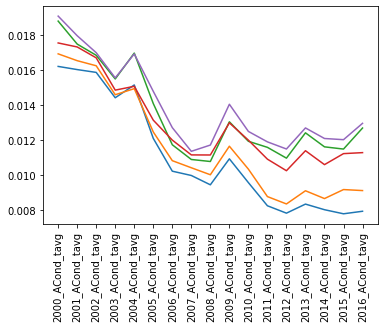

In [29]:
plt.xticks(rotation=90)
for i in range(5):
    plt.plot(acond_tavg.iloc[i])

In [30]:

def glm_fit_per_cell(varname):
    v = master_df.filter(regex=(".*_%s$" % varname))
    years = [int(re.search("(.*)_%s" % varname, s).group(1)) for s in v.columns]
    min_year = min(years)
    max_year = max(years)
    x = np.arange(min_year, max_year + 1).reshape((-1, 1))
    rsqrd = []
    models = []
    for y in v.iloc:
        model = LinearRegression().fit(x, y)
        models.append(model)
        rsqrd.append(model.score(x, y))
    return (models, rsqrd)
    
acond_models, acond_rsqrd = glm_fit_per_cell("ACond_tavg")

(array([2497., 1054.,  915.,  824.,  884.,  937., 1127., 1233., 1172.,
         237.]),
 array([1.39917108e-08, 1.00000013e-01, 2.00000011e-01, 3.00000010e-01,
        4.00000008e-01, 5.00000007e-01, 6.00000006e-01, 7.00000004e-01,
        8.00000003e-01, 9.00000001e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

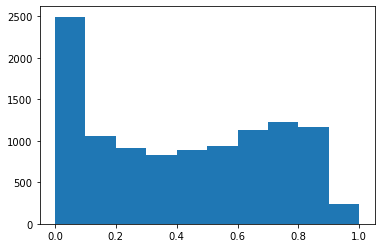

In [31]:
plt.hist(acond_rsqrd)

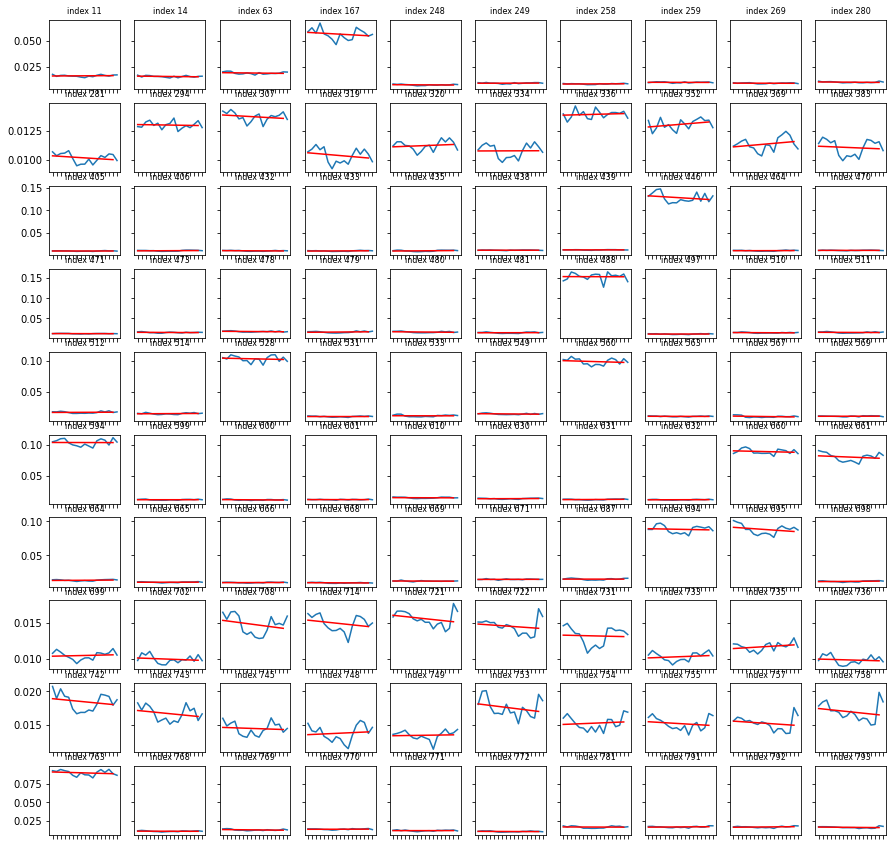

In [32]:
low_scorers = np.where(np.array(acond_rsqrd) < 0.1)[0]
fig, ax = plt.subplots(10, 10, sharex='col', sharey='row', figsize=(15,15))
i = 0
for row in ax:
    for gridplt in row:
        real_idx = low_scorers[i]
        gridplt.set_xticklabels([])
        gridplt.title.set_text('index %d' % real_idx)
        gridplt.title.set_size(8)
        x = np.arange(2000, 2016).reshape((-1, 1))
        y = acond_tavg.iloc[real_idx]
        gridplt.plot(y)
        gridplt.plot([acond_models[real_idx].intercept_ + acond_models[real_idx].coef_[0] * xv for xv in x], 'r')
        i += 1

It is not ideal, but the lines capture the general trend of the variable in each geographical cell.

In [44]:
def project_all_models(df):
    all_vars = [re.search('2000_(.*)', x).group(1) for x in df.filter(regex="2000_.*").columns]
    all_var_models = []
    for v in tqdm(all_vars):
        v_models, _ = glm_fit_per_cell(v)
        all_var_models.append(v_models)
    return all_var_models

def project_cell(df, idx, year, all_models):
    all_vars = [re.search('2000_(.*)', x).group(1) for x in df.filter(regex="2000_.*").columns]
    return [all_models[i][idx].coef_[0] * year + all_models[i][idx].intercept_ for i, v in enumerate(all_vars)]

def project_ssp2_data(df, year):
    # Load GDP/population projections from SSP2
    ssp2_copy = df.copy()
    pop = ssp2_load_population(from_year=year-10, to_year=year+1)
    ssp2_copy = ssp2_copy.merge(pop)
    gdp = ssp2_load_gdp(from_year=year-10, to_year=year+1)
    ssp2_copy = ssp2_copy.merge(gdp)
    return ssp2_copy
    
def project_df(df, year, all_models):
    future_df_spec = {'lon': df['lon'], 'lat': df['lat']}
    future_array = np.array([project_cell(df, i, year, all_models) for i in range(len(df))])
    all_vars = [re.search('2000_(.*)', x).group(1) for x in df.filter(regex="2000_.*").columns]
    for i, var in enumerate(all_vars):
        future_df_spec.update({'%s_%s' % (year, var): future_array[:,i]})
    ssp2_copy = project_ssp2_data(df, year)
    pop_year = 'p2_%s' % year
    gdp_year = 'g2_%s' % year
    future_df_spec.update({gdp_year: ssp2_copy[gdp_year]})
    future_df_spec.update({pop_year: ssp2_copy[pop_year]})
    future_df = dataframe_to_geodataframe(pd.DataFrame(future_df_spec))
    new_df = df.copy()
    return new_df.merge(future_df)

In [45]:
all_var_models = project_all_models(master_df)
future_df = project_df(master_df, 2050, all_var_models)
future_df

100%|██████████| 78/78 [11:03<00:00,  8.51s/it]


,lon,lat,2000_ACond_tavg,2000_Albedo_inst,2000_AvgSurfT_inst,2000_CanopInt_inst,2000_ECanop_tavg,2000_ESoil_tavg,2000_Evap_tavg,2000_LWdown_f_tavg,...,2050_qs,2050_reservoirstor,2050_riverstor,2050_soilmoist,2050_swe,2050_tws,2050_disnat,2050_ncrunnat,g2_2050,p2_2050
0,-179.5,67.5,0.016219,39.998020,261.982452,0.028931,2.330008,15.343687,0.000009,229.330368,...,0.000026,0.0,1.488575,10.169959,161.046802,270.916386,49.303485,0.000027,1.488680e-07,8.299796e-09
1,-178.5,67.5,0.016937,40.676281,262.283844,0.036311,2.233058,15.203341,0.000009,229.323456,...,0.000021,0.0,24.910480,14.462152,127.916474,287.398170,260.792866,0.000023,1.975025e-06,1.041296e-07
2,-177.5,66.5,0.018806,39.602760,263.464081,0.022502,1.618066,16.863810,0.000009,238.398178,...,0.000022,0.0,1.348462,22.316837,158.335091,193.445806,35.564006,0.000023,1.248700e-10,6.272343e-12
3,-177.5,67.5,0.017559,40.260284,263.129944,0.031821,2.382056,14.701731,0.000009,235.138351,...,0.000013,0.0,7.579524,21.924630,129.470585,191.178559,128.054133,0.000013,9.669922e-07,4.876056e-08
4,-176.5,66.5,0.019091,39.242260,263.903259,0.020268,1.530059,16.375177,0.000009,238.532364,...,0.000020,0.0,2.808489,20.629852,144.748873,172.991597,32.058340,0.000020,1.907579e-09,9.607283e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10875,178.5,66.5,0.015414,39.112247,263.983429,0.027007,1.653442,18.262630,0.000010,237.184082,...,0.000025,0.0,2.032639,18.606742,225.869671,302.019074,67.927078,0.000025,1.271202e-04,6.943921e-06
10876,178.5,67.5,0.014983,40.879303,260.781891,0.017122,1.584615,15.298200,0.000009,226.266846,...,0.000020,0.0,2.527283,27.676480,331.233438,482.990880,43.068518,0.000022,9.395860e-05,5.354371e-06
10877,178.5,68.5,0.013615,-796.932922,259.243500,0.017424,1.510876,12.922237,0.000008,224.636765,...,0.000011,0.0,1.343047,8.194586,151.538912,377.194433,18.484051,0.000013,2.066604e-05,1.139748e-06
10878,179.5,66.5,0.015795,39.452206,263.995148,0.018649,1.290685,19.071337,0.000010,236.835693,...,0.000026,0.0,24.616773,28.492540,233.952552,304.293173,145.065752,0.000026,4.255106e-05,2.355910e-06


In [46]:
future_df.filter(regex=".*2050.*")

,2050_ACond_tavg,2050_Albedo_inst,2050_AvgSurfT_inst,2050_CanopInt_inst,2050_ECanop_tavg,2050_ESoil_tavg,2050_Evap_tavg,2050_LWdown_f_tavg,2050_Lwnet_tavg,2050_Psurf_f_inst,...,2050_qs,2050_reservoirstor,2050_riverstor,2050_soilmoist,2050_swe,2050_tws,2050_disnat,2050_ncrunnat,g2_2050,p2_2050
0,-0.013869,-925.042221,250.929574,0.029180,3.752627,24.536195,0.000012,189.540770,-44.851951,94761.175551,...,0.000026,0.0,1.488575,10.169959,161.046802,270.916386,49.303485,0.000027,1.488680e-07,8.299796e-09
1,-0.011389,72.577574,254.058168,0.022557,4.405940,25.275895,0.000013,198.141227,-47.528701,101079.139476,...,0.000021,0.0,24.910480,14.462152,127.916474,287.398170,260.792866,0.000023,1.975025e-06,1.041296e-07
2,-0.003665,33.197989,258.834864,0.016525,3.227895,26.701101,0.000013,202.450659,-56.975382,97894.578929,...,0.000022,0.0,1.348462,22.316837,158.335091,193.445806,35.564006,0.000023,1.248700e-10,6.272343e-12
3,-0.004645,-1109.564013,257.299404,0.016314,3.921367,25.212307,0.000013,201.360342,-54.558425,101690.394761,...,0.000013,0.0,7.579524,21.924630,129.470585,191.178559,128.054133,0.000013,9.669922e-07,4.876056e-08
4,-0.002767,32.830386,259.587475,0.023407,3.655577,25.551612,0.000013,203.671407,-58.685369,100679.494830,...,0.000020,0.0,2.808489,20.629852,144.748873,172.991597,32.058340,0.000020,1.907579e-09,9.607283e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10875,-0.004671,32.436099,258.269015,0.023779,4.567940,32.097315,0.000017,203.560904,-55.888015,99990.368107,...,0.000025,0.0,2.032639,18.606742,225.869671,302.019074,67.927078,0.000025,1.271202e-04,6.943921e-06
10876,-0.014454,-226.978261,255.300737,0.021937,3.521912,32.012160,0.000015,194.714345,-55.325165,96549.072381,...,0.000020,0.0,2.527283,27.676480,331.233438,482.990880,43.068518,0.000022,9.395860e-05,5.354371e-06
10877,-0.010815,-803.639743,253.347366,0.032414,4.313263,28.691743,0.000015,191.443827,-53.178857,99531.502872,...,0.000011,0.0,1.343047,8.194586,151.538912,377.194433,18.484051,0.000013,2.066604e-05,1.139748e-06
10878,-0.007007,30.679041,261.504620,0.026342,3.783810,33.666969,0.000016,215.281378,-55.785559,106552.358571,...,0.000026,0.0,24.616773,28.492540,233.952552,304.293173,145.065752,0.000026,4.255106e-05,2.355910e-06


In [52]:
future_df = future_df[future_df['WPI'] != 0]
future_df

,lon,lat,2000_ACond_tavg,2000_Albedo_inst,2000_AvgSurfT_inst,2000_CanopInt_inst,2000_ECanop_tavg,2000_ESoil_tavg,2000_Evap_tavg,2000_LWdown_f_tavg,...,g2_2050,p2_2050,index_right,FID,the_geom,OBJECTID,ISO,NAME,UNESCOMEMB,WPI
0,-179.5,67.5,0.016219,39.998020,261.982452,0.028931,2.330008,15.343687,0.000009,229.330368,...,1.488680e-07,8.299796e-09,209,wpif.211,MULTIPOLYGON (((146.01804100000004 43.37793940...,204,RUS,Russian Federation,Russian Federation,63.4
1,-178.5,67.5,0.016937,40.676281,262.283844,0.036311,2.233058,15.203341,0.000009,229.323456,...,1.975025e-06,1.041296e-07,209,wpif.211,MULTIPOLYGON (((146.01804100000004 43.37793940...,204,RUS,Russian Federation,Russian Federation,63.4
2,-177.5,66.5,0.018806,39.602760,263.464081,0.022502,1.618066,16.863810,0.000009,238.398178,...,1.248700e-10,6.272343e-12,209,wpif.211,MULTIPOLYGON (((146.01804100000004 43.37793940...,204,RUS,Russian Federation,Russian Federation,63.4
3,-177.5,67.5,0.017559,40.260284,263.129944,0.031821,2.382056,14.701731,0.000009,235.138351,...,9.669922e-07,4.876056e-08,209,wpif.211,MULTIPOLYGON (((146.01804100000004 43.37793940...,204,RUS,Russian Federation,Russian Federation,63.4
4,-176.5,66.5,0.019091,39.242260,263.903259,0.020268,1.530059,16.375177,0.000009,238.532364,...,1.907579e-09,9.607283e-11,209,wpif.211,MULTIPOLYGON (((146.01804100000004 43.37793940...,204,RUS,Russian Federation,Russian Federation,63.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10811,169.5,-44.5,0.022976,19.539923,275.850525,0.094677,7.432333,31.183109,0.000018,292.664368,...,1.072314e-01,3.736610e-03,189,wpif.189,MULTIPOLYGON (((169.1988525390001 -52.46692275...,179,NZL,New Zealand,New Zealand,60.8
10819,170.5,-44.5,0.024121,17.699976,278.923218,0.073006,9.571005,40.399059,0.000024,296.372131,...,7.580758e-02,2.584735e-03,189,wpif.189,MULTIPOLYGON (((169.1988525390001 -52.46692275...,179,NZL,New Zealand,New Zealand,60.8
10835,172.5,-42.5,0.024165,14.778844,278.754700,0.151941,12.595078,33.358429,0.000023,311.685425,...,1.196153e-01,4.282661e-03,189,wpif.189,MULTIPOLYGON (((169.1988525390001 -52.46692275...,179,NZL,New Zealand,New Zealand,60.8
10857,175.5,-38.5,0.020660,17.081402,285.399811,0.174712,12.089117,27.376980,0.000018,322.678406,...,1.380618e+00,3.346965e-02,189,wpif.189,MULTIPOLYGON (((169.1988525390001 -52.46692275...,179,NZL,New Zealand,New Zealand,60.8


In [ ]:
# Do not uncomment this unless you want to save a new version of the FUTURE dataframe
# save_checkpoint(future_df, name='data/future_df.pickle')

future_df = load_checkpoint('data/future_df.pickle')

In [131]:
# long_future_df = master_df.copy()
# for i in tqdm(range(2040, 2051)):
#     long_future_df = project_df(long_future_df, i, all_var_models)
# long_future_df = geodataframe_merge_wpi(long_future_df)
# save_checkpoint(long_future_df, name='data/long_future_df.pickle')

long_future_df = load_checkpoint('data/long_future_df.pickle')

100%|██████████| 11/11 [25:29<00:00, 139.05s/it]


# Predicting the future with Lasso

In [56]:
def rename_year_hack(column, from_year, to_year):
    return column.replace(str(from_year), str(to_year))

future_df_2050 = future_df.filter(regex=".*2050.*").rename(columns=lambda x: rename_year_hack(x, 2050, 2016))
future_lasso_predictions = lasso.predict(xscaler.transform(future_df_2050))

In [82]:
lasso_dict = {}
for country in set(future_df['NAME']):
    lasso_dict[country] = {}
    lasso_dict[country]['past'] = np.median(future_df[future_df['NAME'] == country]['WPI'])
    f_val = yscaler.inverse_transform(np.median(future_lasso_predictions[future_df['NAME'] == country].astype(float)).reshape(-1,1))
    lasso_dict[country]['future'] = f_val[0][0]
    lasso_dict[country]['diff'] = lasso_dict[country]['future'] - lasso_dict[country]['past']

In [89]:
def top_countries_abs(d, n=5, inv=1):
    return sorted([(k, d[k]['future']) for k in d.keys()], key=lambda x: x[1]*inv)[:n]

top_losers_abs  = top_countries_abs(lasso_dict, n=10)
top_winners_abs = top_countries_abs(lasso_dict, inv=-1, n=10)

In [90]:
top_winners_abs

[('Denmark', 74.24498805694853),
 ('Canada', 66.81897004240525),
 ('Finland', 65.67253683161832),
 ('Russian Federation', 65.03577777712765),
 ('Kazakhstan', 64.24557096308618),
 ('Sweden', 63.88739365083881),
 ('Belarus', 63.52753596903599),
 ('Poland', 63.141000458369625),
 ('Ireland', 63.110674113394474),
 ('Norway', 62.011918868563356)]

In [139]:
", ".join([x[0] for x in top_winners_abs])

'Denmark, Canada, Finland, Russian Federation, Kazakhstan, Sweden, Belarus, Poland, Ireland, Norway'

In [91]:
top_losers_abs

[('Equatorial Guinea', 38.93268004489656),
 ('Guyana', 41.67436345707113),
 ('Eritrea', 44.53209774286637),
 ('Yemen', 45.758972146729),
 ('Colombia', 46.223322186749044),
 ('Malaysia', 46.66981442798093),
 ('Sierra Leone', 46.87916926500728),
 ('Guatemala', 48.536721531359014),
 ('Guinea', 48.71070704260905),
 ('Oman', 49.16518134312652)]

In [140]:
", ".join([x[0] for x in top_losers_abs])

'Equatorial Guinea, Guyana, Eritrea, Yemen, Colombia, Malaysia, Sierra Leone, Guatemala, Guinea, Oman'

# Predicting the future with LSTM

In [119]:
countries = list(set(future_df['ISO']))
future_seqs, future_targets = sequify_countries(countries,
                                                future_df,
                                                interesting_columns=lambda x: rnn_interesting_columns(x, year=2050))
future_seqs = torch.from_numpy(future_seqs.astype(np.float32))
future_seqs.to(device)
output, _ = lstm_model(future_seqs)

In [124]:
lstm_dict = {}
for i, country_iso in enumerate(countries):
    country = future_df[future_df['ISO'] == country_iso]['NAME'].iloc[0]
    lstm_dict[country] = {}
    lstm_dict[country]['past'] = np.median(future_df[future_df['NAME'] == country]['WPI'])
    f_val = yscaler.inverse_transform(output.detach().numpy().reshape(-1, 1))[i]
    lstm_dict[country]['future'] = f_val
    lstm_dict[country]['diff'] = lstm_dict[country]['future'] - lstm_dict[country]['past']

In [128]:
# LSTM winners
top_countries_abs(lstm_dict, inv=-1, n=10)

[('Indonesia', array([64.57674], dtype=float32)),
 ('United States of America', array([64.5749], dtype=float32)),
 ('Germany', array([64.57302], dtype=float32)),
 ('Brazil', array([64.57104], dtype=float32)),
 ('Finland', array([64.57047], dtype=float32)),
 ('Russian Federation', array([64.569214], dtype=float32)),
 ('Paraguay', array([64.55324], dtype=float32)),
 ('Norway', array([64.55183], dtype=float32)),
 ('Poland', array([64.551254], dtype=float32)),
 ('Belarus', array([64.551125], dtype=float32))]

In [141]:
", ".join([x[0] for x in top_countries_abs(lstm_dict, inv=-1, n=10)])

'Indonesia, United States of America, Germany, Brazil, Finland, Russian Federation, Paraguay, Norway, Poland, Belarus'

In [127]:
# LSTM losers
top_countries_abs(lstm_dict, n=10)

[('Lesotho', array([47.34186], dtype=float32)),
 ('Mozambique', array([49.440327], dtype=float32)),
 ('United Republic of Tanzania', array([49.806164], dtype=float32)),
 ('Kenya', array([50.014473], dtype=float32)),
 ('Madagascar', array([50.45786], dtype=float32)),
 ('India', array([51.371765], dtype=float32)),
 ('Zambia', array([51.61372], dtype=float32)),
 ('Pakistan', array([51.64002], dtype=float32)),
 ('Angola', array([52.359493], dtype=float32)),
 ('Morocco', array([52.36529], dtype=float32))]

In [142]:
", ".join([x[0] for x in top_countries_abs(lstm_dict, n=10)])

'Lesotho, Mozambique, United Republic of Tanzania, Kenya, Madagascar, India, Zambia, Pakistan, Angola, Morocco'